# Imports

In [80]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
import pdb

from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, Conv2D, MaxPooling2D
from keras.utils import np_utils

# Distinguish Gaussians from Lorentzians, and predicting the mean, standard deviation if Gaussian

## Plot CNN results

In [63]:
def predict(model):
    #pdb.set_trace()
    # Make 1000 new Gaussians to apply the model to
    predX, predy = make_gaussians(1000)
    
    # Apply the model to get predicted means and sigmas of the Gaussians
    pmeans, psigs = model.predict(predX, batch_size=None, verbose=0)
    
    # Check distribution of difference between true and predicted means, sigmas
    plt.subplot(211)
    _, _, _ = plt.hist(predy[:, 0] - pmeans.flatten(), bins=30)
    plt.subplot(212)
    _, _, _ = plt.hist(predy[:, 1] - psigs.flatten(), bins=30)
    
    plt.show()
    
    # Check the relation between true and predicted means, sigmas
    oto_means = np.linspace(-1., 1., 32) # one-to-one relation for means
    oto_sigmas = np.linspace(0.25, 4.0, 32) # one-to-one relation for sigmas
    
    plt.subplot(211)
    # Plot the true y's and predicted y's from the NN model
    plt.plot(predy[:, 0], pmeans.flatten(), marker='.')
    # Plot the 1-to-1 line
    plt.plot(oto_means, oto_means, color='black', ls='--')
    plt.xlim(-1.0, 1.0)
    plt.ylim(-1.0, 1.0)
    plt.xlabel('True value')
    plt.ylabel('Predicted value')
    plt.title(r'$\mu$')
    
    plt.subplot(212)
    plt.plot(predy[:, 1], psigs.flatten(), marker='.')
    plt.plot(oto_sigmas, oto_sigmas, color='black', ls='--')
    plt.xlim(0.25, 4.0)
    plt.ylim(0.25, 4.0)
    plt.xlabel('True value')
    plt.ylabel('Predicted value')
    plt.title(r'$\sigma$')
    
    #plt.savefig('gaussian_characteristics.pdf')
    plt.show()

## Generate distributions

### 1D Gaussian

In [19]:
# Calculate a Gaussian given its mean and standard deviation
def gaussian(x_vals, mu, sigma):
    return np.exp(-0.5 * ((x_vals - mu)/sigma)**2) / (sigma * np.sqrt(2*np.pi))

# Make array that describes Gaussian
def make_gaussians(num, mu_min=-1.0, mu_max=1.0, sig_min=0.25, sig_max=4.0): 

    means = np.random.uniform(mu_min, mu_max, num)
    sigmas = np.random.uniform(sig_min, sig_max, num)

    x_vals = np.linspace(-10.0, 10.0, 32)
    models = np.zeros((num, 32))

    for i in range(num):
        models[i] = gaussian(x_vals, means[i], sigmas[i])
    
    # Also want to save and return the true means, sigmas used for the Gaussians
    targets = np.vstack((means, sigmas)).T

    return models, targets

### 1D Lorentzian

In [3]:
# Calculate a Lorentzian distribution given its location parameter and scale parameter
def lorentzian(x_vals, loc, scale):
    return ( 1/(np.pi*scale) ) * ( scale**2 / ((x_vals - loc)**2 + (scale)**2) )

def make_lorentzians(num, loc_min=-1.0, loc_max=1.0, scale_min=0.25, scale_max=4.0):
    
    locs = np.random.uniform(loc_min, loc_max, num)
    scales = np.random.uniform(scale_min, scale_max, num)
    
    x_vals = np.linspace(-10.0, 10.0, 32)
    models = np.zeros((num, 32))
    
    for i in range(num):
        models[i] = lorentzian(x_vals, locs[i], scales[i])
        
    targets = np.vstack((locs, scales)).T
    
    return models, targets

#### Plot to check Lorentzian function

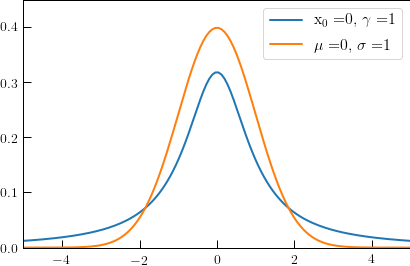

In [145]:
x_vals = np.linspace(-10.0, 10.0, 2**8)

plt.plot(x_vals, lorentzian(x_vals, 0.0, 1.0), label=r'x$_{0}=$0, $\gamma=$1')
plt.plot(x_vals, gaussian(x_vals, 0.0, 1.0), label=r'$\mu=$0, $\sigma=$1')
plt.xlim(-5, 5)
plt.ylim(0.0, 0.45)
plt.legend(fontsize=16)

plt.show()

# Just Classification

## Generate dataset

In [118]:
# Create training and test sets
def generate_dataset(n_train=10000, n_test=1000, frac_gauss=None):
    # From desired training and test set sizes, determine the fraction that is Gaussian vs Lorentzian
    
    # Random fraction w/limits to avoid too many of any one kind
    if frac_gauss is None:
        fg_train = np.random.uniform(0.25, 0.75)
        fg_test = np.random.uniform(0.25, 0.75)
    
    # User-identified fraction
    elif frac_gauss < 1.0:
        fg_train = fg_test = frac_gauss
        
    num_gauss_train = int(fg_train * n_train)
    num_gauss_test =  int(fg_test * n_test)
    
    num_lorentz_train = n_train - num_gauss_train
    num_lorentz_test = n_test - num_gauss_test
    
    print (num_gauss_train, num_lorentz_train, num_gauss_test, num_lorentz_test)

    # Generate training and test sets
    X_train_gauss, _ = make_gaussians(num_gauss_train)
    X_test_gauss, _  = make_gaussians(num_gauss_test)

    X_train_lorentz, _ = make_lorentzians(num_lorentz_train)
    X_test_lorentz, _ = make_lorentzians(num_lorentz_test)
    
    # Classification
    y_train = np.ones(n_train)
    y_train[0:num_gauss_train] *= 0.0 # Gaussians are 0s
    y_train = np_utils.to_categorical(y_train)
    
    y_test = np.ones(n_test)
    y_test[0:num_gauss_test] *= 0.0 # Gaussians are 0s
    y_test = np_utils.to_categorical(y_test)

    # Combine Gaussian and Lorentzians
    X_train = np.concatenate((X_train_gauss, X_train_lorentz))
    X_test = np.concatenate((X_test_gauss, X_test_lorentz))
    
    return X_train, y_train, X_test, y_test

## Create, compile, fit, and evaluate NN model

In [129]:
# Define baseline model
def baseline_model():
    # Create model
    model = Sequential()
    model.add(Dense(32, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
    # There are 2 classes -- Gaussian or Lorentzian -- hence the Dense(2)
    model.add(Dense(2, kernel_initializer='normal', activation='softmax')) 
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [131]:
# Build the model
model = baseline_model()

# Create dataset and fit the model
X_train, y_train, X_test, y_test = generate_dataset()
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=128, verbose=1)

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Train on 10000 samples, validate on 1000 samples
Epoch 1/100
10000/10000 [==============================] - 0s 20us/step - loss: 0.6381 - accuracy: 0.6972 - val_loss: 0.7793 - val_accuracy: 0.4590
Epoch 2/100
10000/10000 [==============================] - 0s 11us/step - loss: 0.5726 - accuracy: 0.7012 - val_loss: 0.7669 - val_accuracy: 0.4590
Epoch 3/100
10000/10000 [==============================] - 0s 11us/step - loss: 0.5456 - accuracy: 0.7012 - val_loss: 0.7275 - val_accuracy: 0.4590
Epoch 4/100
10000/10000 [==============================] - 0s 10us/step - loss: 0.5084 - accuracy: 0.7032 - val_loss: 0.6641 - val_accuracy: 0.5210
Epoch 5/100
10000/10000 [==============================] - 0s 11us/step - loss: 0.4650 - accuracy: 0.7645 - val_loss: 0.6201 - val_accuracy: 0.6220
Epoch 6/100
10000/10000 [==============================] - 0s 11us/step - loss: 0.4214 - accuracy: 0.8021 - val_loss: 0.5545 - val_accuracy: 0.6890
Epoch 7/100
10000/10000 [==============================] - 0s 1

Epoch 56/100
10000/10000 [==============================] - 0s 12us/step - loss: 0.0117 - accuracy: 0.9994 - val_loss: 0.0164 - val_accuracy: 0.9980
Epoch 57/100
10000/10000 [==============================] - 0s 12us/step - loss: 0.0111 - accuracy: 0.9994 - val_loss: 0.0154 - val_accuracy: 0.9990
Epoch 58/100
10000/10000 [==============================] - 0s 12us/step - loss: 0.0106 - accuracy: 0.9994 - val_loss: 0.0150 - val_accuracy: 0.9980
Epoch 59/100
10000/10000 [==============================] - 0s 11us/step - loss: 0.0101 - accuracy: 0.9994 - val_loss: 0.0144 - val_accuracy: 0.9980
Epoch 60/100
10000/10000 [==============================] - 0s 10us/step - loss: 0.0097 - accuracy: 0.9994 - val_loss: 0.0135 - val_accuracy: 0.9990
Epoch 61/100
10000/10000 [==============================] - 0s 10us/step - loss: 0.0092 - accuracy: 0.9995 - val_loss: 0.0131 - val_accuracy: 0.9990
Epoch 62/100
10000/10000 [==============================] - 0s 10us/step - loss: 0.0088 - accuracy: 0.9995

In [138]:
_, _, new_X, new_y = generate_dataset(n_train=10, n_test=1000)
model.evaluate(new_X, new_y)

2 8 680 320
1000/1000 [==============================] - 0s 24us/step


[0.0030457507157698274, 0.9990000128746033]

# Classify and Regress

In [139]:
# Create training and test sets
def generate_dataset(n_train=10000, n_test=1000, frac_gauss=None):
    # From desired training and test set sizes, determine the fraction that is Gaussian vs Lorentzian
    
    # Random fraction w/limits to avoid too many of any one kind
    if frac_gauss is None:
        fg_train = np.random.uniform(0.25, 0.75)
        fg_test = np.random.uniform(0.25, 0.75)
    
    # User-identified fraction
    elif frac_gauss < 1.0:
        fg_train = fg_test = frac_gauss
        
    num_gauss_train = int(fg_train * n_train)
    num_gauss_test =  int(fg_test * n_test)
    
    num_lorentz_train = n_train - num_gauss_train
    num_lorentz_test = n_test - num_gauss_test
    
    print (num_gauss_train, num_lorentz_train, num_gauss_test, num_lorentz_test)

    # Generate training and test sets
    X_train_gauss, y_train_gauss = make_gaussians(num_gauss_train)
    X_test_gauss, y_test_gauss = make_gaussians(num_gauss_test)

    X_train_lorentz, y_train_lorentz = make_lorentzians(num_lorentz_train)
    X_test_lorentz, y_test_lorentz = make_lorentzians(num_lorentz_test)

    # Combine Gaussian and Lorentzians
    X_train = np.concatenate((X_train_gauss, X_train_lorentz))
    y_train = np.concatenate((y_train_gauss, y_train_lorentz))
    X_test = np.concatenate((X_test_gauss, X_test_lorentz))
    y_test = np.concatenate((y_test_gauss, y_test_lorentz))
    
    # Want to classify the arrays too...
    
    return X_train, y_train, X_test, y_test